In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from astroML.datasets import sdss_corrected_spectra
import scipy.sparse as sps
from scipy.sparse.linalg import eigsh
from sklearn.neighbors import kneighbors_graph

In [ ]:
# adapted from https://github.com/stephenportillo/SDSS-VAE/blob/master/SDSS-VAE.ipynb
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
rawspec = sdss_corrected_spectra.reconstruct_spectra(data)
lam = sdss_corrected_spectra.compute_wavelengths(data)

spec = rawspec / data['norms'][:,None] 
meanspec = np.mean(spec, axis=0)
nfeat = meanspec.size

X = spec - meanspec # Normalize data

### Set Classes

In [172]:
specclass = data['lineindex_cln']
# stars have lineindex_cln 1, 9
stars = (specclass == 1) + (specclass == 9)
starsidx = np.where(stars)[0]
# map lineindex_cln 2,3 to 0 and 4,5,6 to 1,2,3
specclass -= 3
specclass[specclass == -1] = 0 # set line_index 2 -> 0
specclass[specclass < -1] = -1
specclass[specclass > 3] = -1
specclassnames = ['quiescent galaxy', 'emission-line galaxy', 'narrow-line AGN', 'broad-line AGN']

### Set Colors

In [173]:
from matplotlib.colors import ListedColormap
#tableau colorblind 10
colors = [(0., 107/256, 164/256), (255/256, 128/256, 14/256), (89/256, 89/256, 89/256), (171/256, 171/256, 171/256)]
cmapclass = ListedColormap(colors)

### Plot a spectra

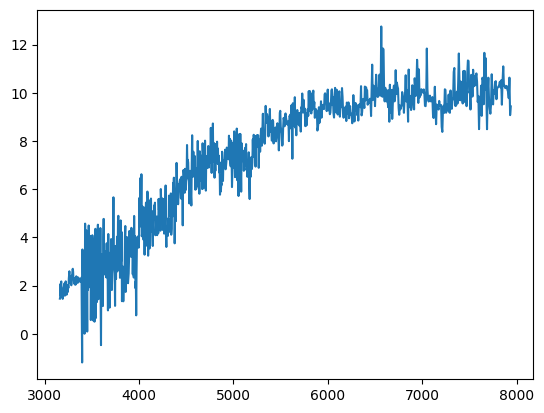

In [150]:
plt.plot(lam, rawspec[4])

### Generate an embedding

In [203]:
# ----------------------------
# Laplacian Eigenmaps (Belkin–Niyogi style)
# ----------------------------
k = 600

# Sparse kNN distance graph (only edges), exclude self-neighbor
G = kneighbors_graph(X, n_neighbors=k, mode="distance", include_self=False)

s = 36

# Heat kernel weights on edges
G.data = np.exp(-(G.data**2) / (2 * (s ** 2)))

# Symmetrize W (undirected graph)
W = 0.5 * (G + G.T)

# Degree and Laplacian (sparse)
d = np.asarray(W.sum(axis=1)).ravel() + 1e-8
D = sps.diags(d)
L = D - W

# Generalized eigenproblem: (D - W) v = λ D v
# Compute smallest eigenpairs: need 1 extra to drop the trivial eigenvector
vals, vecs = eigsh(L, M=D, which='SM')  # SM = smallest magnitude
idx = np.argsort(vals)
vals, vecs = vals[idx], vecs[:, idx]

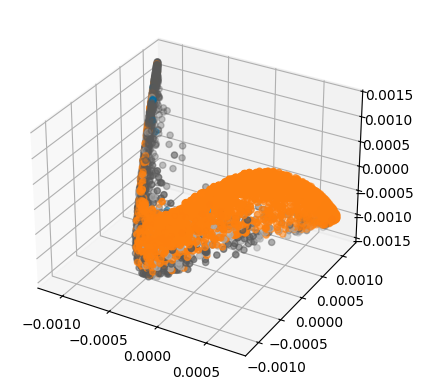

In [204]:
X_le = vecs[:, 1:]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_le[:, 0], X_le[:, 1], X_le[:, 2], c=specclass, cmap=cmapclass)
plt.show()

### Generate Eigenvectors for Different $k$ and $s$

In [196]:
ks = [4, 16, 32, 64, 128, 256, 512]
ss = [4, 16, 32, 64, 128, 256, 512]

vals_list = []
vecs_list = []

for i in range(len(ks) * len(ss)):
    # ----------------------------
    # Laplacian Eigenmaps (Belkin–Niyogi style)
    # ----------------------------
    k = ks[i // len(ss)]

    # Sparse kNN distance graph (only edges), exclude self-neighbor
    G = kneighbors_graph(X, n_neighbors=k, mode="distance", include_self=False)

    # Choose bandwidth s ~ median kNN distance (robust)
    s = ss[i % len(ks)]
    print(f"Generating eigenvectors for k: {k}, s: {s}")

    # Heat kernel weights on edges
    G.data = np.exp(-(G.data**2) / (2 * (s ** 2)))

    # Symmetrize W (undirected graph)
    W = 0.5 * (G + G.T)

    # Degree and Laplacian (sparse)
    d = np.asarray(W.sum(axis=1)).ravel() + 1e-8
    D = sps.diags(d)
    L = D - W

    # Generalized eigenproblem: (D - W) v = λ D v
    # Compute smallest eigenpairs: need 1 extra to drop the trivial eigenvector
    vals, vecs = eigsh(L, M=D, which='SM')  # SM = smallest magnitude
    idx = np.argsort(vals)
    vals, vecs = vals[idx], vecs[:, idx]

    vals_list.append(vals)
    vecs_list.append(vecs)

Generating eigenvectors for k: 4, s: 4
Generating eigenvectors for k: 4, s: 16
Generating eigenvectors for k: 4, s: 32
Generating eigenvectors for k: 4, s: 64
Generating eigenvectors for k: 4, s: 128
Generating eigenvectors for k: 4, s: 256
Generating eigenvectors for k: 4, s: 512
Generating eigenvectors for k: 16, s: 4
Generating eigenvectors for k: 16, s: 16
Generating eigenvectors for k: 16, s: 32
Generating eigenvectors for k: 16, s: 64
Generating eigenvectors for k: 16, s: 128
Generating eigenvectors for k: 16, s: 256
Generating eigenvectors for k: 16, s: 512
Generating eigenvectors for k: 32, s: 4
Generating eigenvectors for k: 32, s: 16
Generating eigenvectors for k: 32, s: 32
Generating eigenvectors for k: 32, s: 64
Generating eigenvectors for k: 32, s: 128
Generating eigenvectors for k: 32, s: 256
Generating eigenvectors for k: 32, s: 512
Generating eigenvectors for k: 64, s: 4
Generating eigenvectors for k: 64, s: 16
Generating eigenvectors for k: 64, s: 32
Generating eigenve

### Generate plot with first and second eigenvectors

In [ ]:
# Add figure
fig = plt.figure(figsize=(len(ss) * 5, len(ks) * 5))
fig.subplots_adjust(hspace=0)

for i in range(len(ks) * len(ss)):    
    X_le = vecs_list[i][:, 1:]  # drop trivial constant eigenvector
    ax = fig.add_subplot(len(ks), len(ss), i+1)
    ax.scatter(X_le[:, 0], X_le[:, 1], c=specclass, cmap=cmapclass)

    if i % len(ss) == 0:
        ax.set_ylabel(f'k = {k}')
    if i // len(ss) == len(ks) - 1:
        ax.set_xlabel(f's = {s}')

plt.legend(title='classes')
plt.show()

### Generate plot for first and third eigenvectors

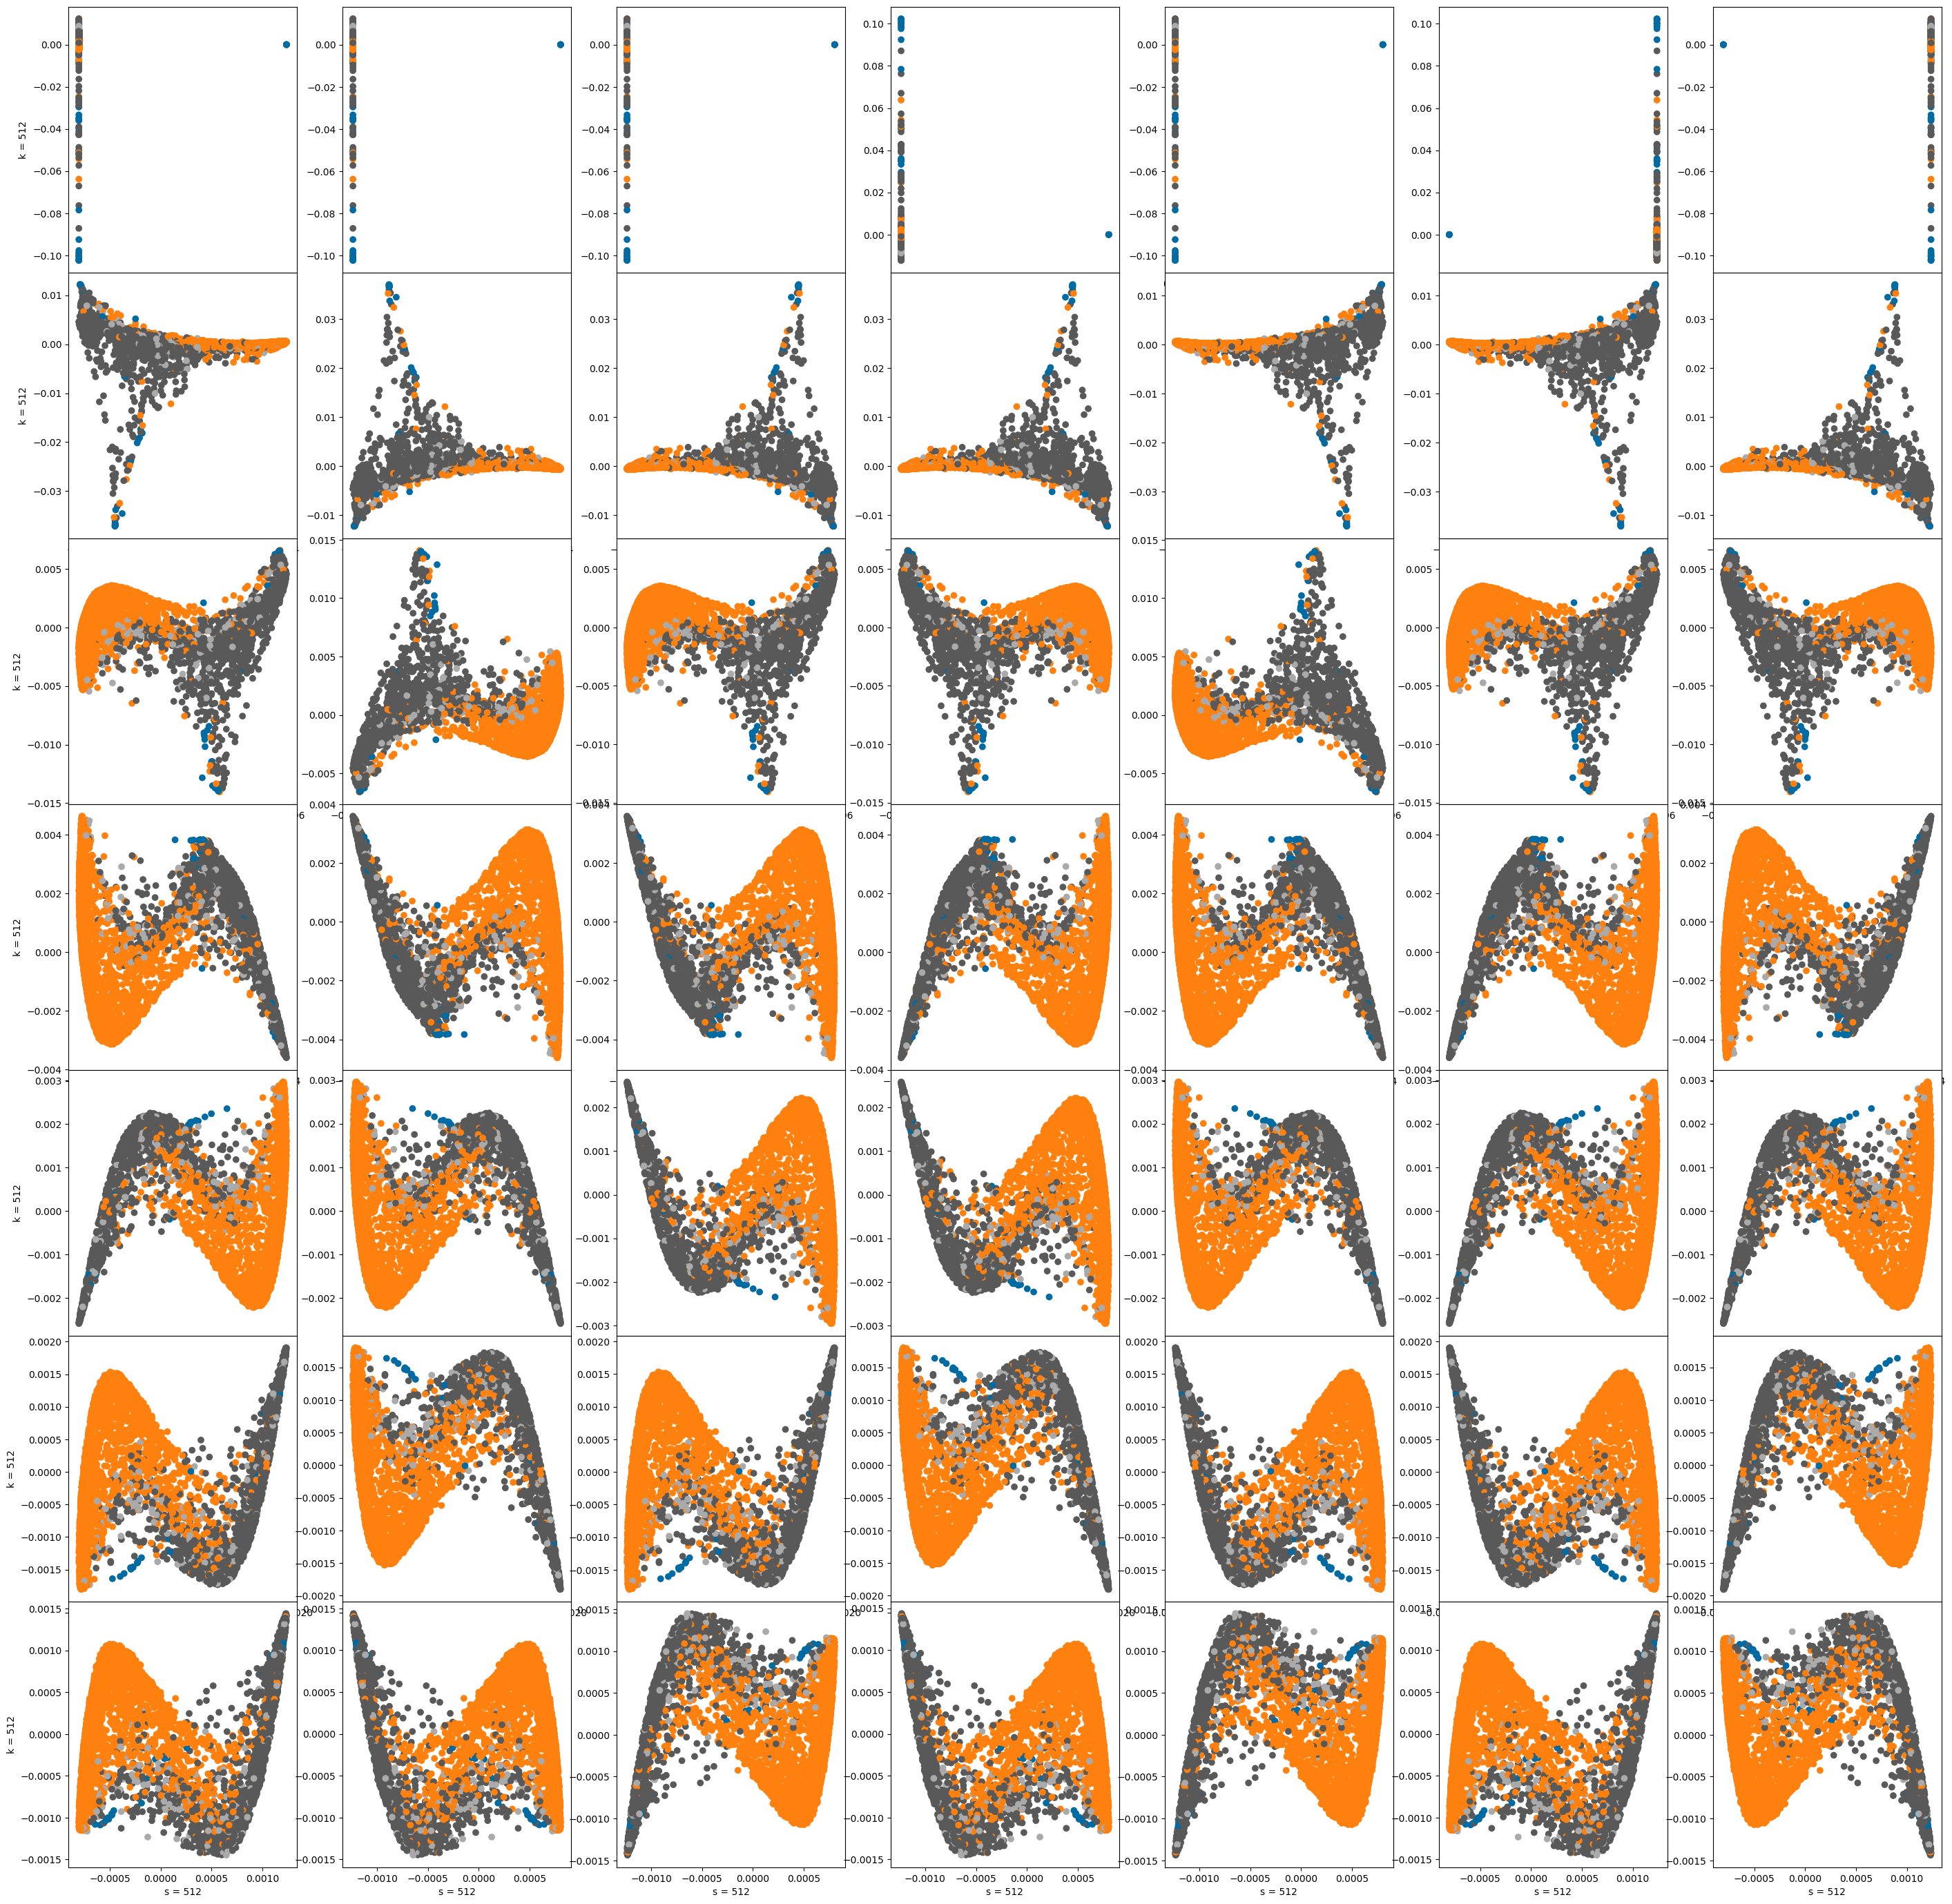

In [ ]:
# Add figure
fig = plt.figure(figsize=(len(ss) * 5, len(ks) * 5))
fig.subplots_adjust(hspace=0)

for i in range(len(ks) * len(ss)):    
    X_le = vecs_list[i][:, 1:]  # drop trivial constant eigenvector
    ax = fig.add_subplot(len(ks), len(ss), i+1)
    ax.scatter(X_le[:, 0], X_le[:, 2], c=specclass, cmap=cmapclass)

    if i % len(ss) == 0:
        ax.set_ylabel(f'k = {k}')
    if i // len(ss) == len(ks) - 1:
        ax.set_xlabel(f's = {s}')

plt.savefig('../figures/galaxy_spectra_different_hyp_vec_1&3.png')
plt.show()

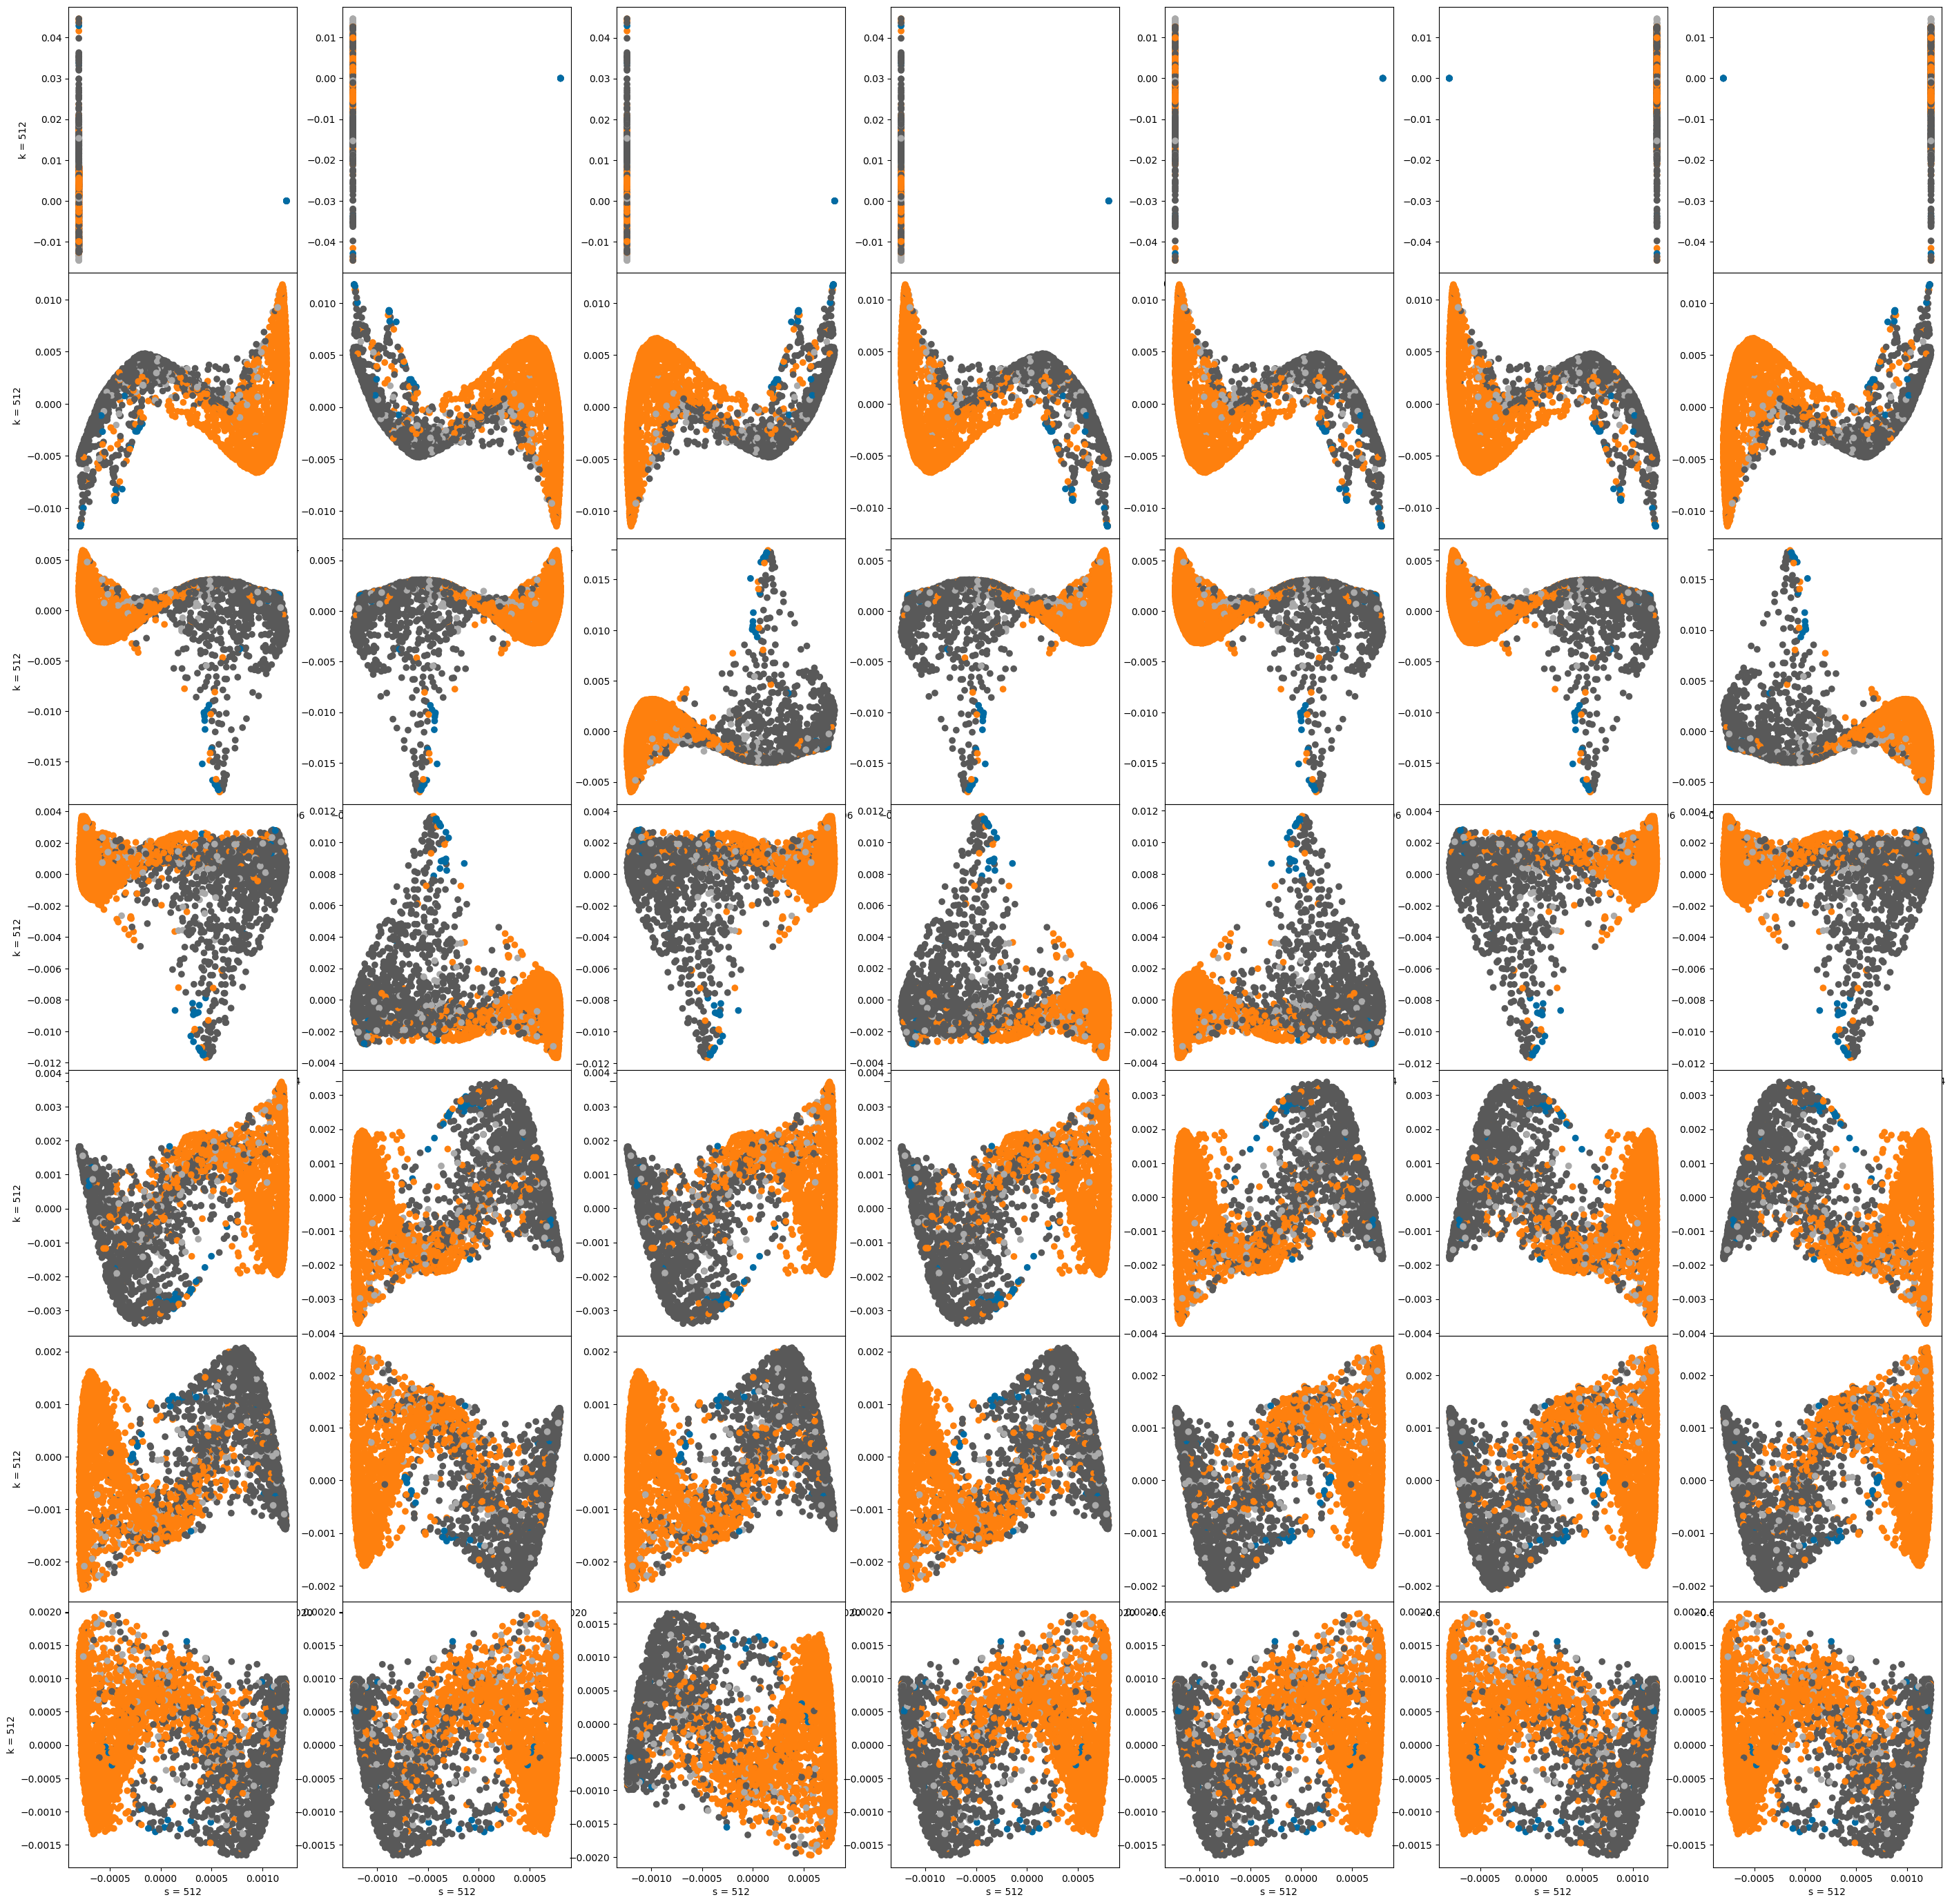

In [202]:
# Add figure
fig = plt.figure(figsize=(len(ss) * 5, len(ks) * 5))
fig.subplots_adjust(hspace=0)

for i in range(len(ks) * len(ss)):    
    X_le = vecs_list[i][:, 1:]  # drop trivial constant eigenvector
    ax = fig.add_subplot(len(ks), len(ss), i+1)
    ax.scatter(X_le[:, 0], X_le[:, 3], c=specclass, cmap=cmapclass)

    if i % len(ss) == 0:
        ax.set_ylabel(f'k = {k}')
    if i // len(ss) == len(ks) - 1:
        ax.set_xlabel(f's = {s}')

plt.savefig('../figures/galaxy_spectra_different_hyp_vec_1&4.png')
plt.show()